<a href="https://colab.research.google.com/github/AntoineDps/Courses/blob/main/%20%5BApplication%20Oriented%20Deep%20Learning%5D%20/Teacher%20Solution/Exercise_7_1_CIFAR_10_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tabulate import tabulate
layers = tf.keras.layers

In [ ]:
def plot_examples(X, Y, n=10):
    """ Plot the first n examples for each of the 10 classes in the CIFAR dataset X, Y """
    fig, axes = plt.subplots(n, 10, figsize=(10, n))
    for l in range(10):
        axes[0, l].set_title(cifar10_labels[l], fontsize="smaller")
        m = np.squeeze(Y) == l  # boolean mask: True for all images of label l
        for i in range(n):
            image = X[m][i].astype("uint8")  # imshow expects uint8
            ax = axes[i, l]
            ax.imshow(image, origin="upper")
            ax.set(xticks=[], yticks=[])
    return fig, ax


def plot_prediction(X, Y, Y_predict):
    """
    Plot image X along with predicted probabilities Y_predict.
    X: CIFAR image, shape = (32, 32, 3)
    Y: CIFAR label, one-hot encoded, shape = (10)
    Y_predict: predicted probabilities, shape = (10)
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

    # plot image
    ax1.imshow(X.astype("uint8"), origin="upper")
    ax1.set(xticks=[], yticks=[])

    # plot probabilities
    ax2.barh(np.arange(10), Y_predict, align="center")
    ax2.set(xlim=(0, 1), xlabel="Score", yticks=[])
    for i in range(10):
        c = "red" if (i == np.argmax(Y)) else "black"
        ax2.text(0.05, i, cifar10_labels[i].capitalize(), ha="left", va="center", color=c)



def plot_confusion(Y_true, Y_predict):
    """
    Plot confusion matrix
    Y_true:    array of true classifications (0-9), shape = (N)
    Y_predict: array of predicted classifications (0-9), shape = (N)
    """
    C = np.histogram2d(Y_true, Y_predict, bins=np.linspace(-0.5, 9.5, 11))[0]
    Cn = C / np.sum(C, axis=1)

    fig = plt.figure()
    plt.imshow(Cn, interpolation="nearest", vmin=0, vmax=1, cmap=plt.cm.YlGnBu)
    plt.colorbar()
    plt.xlabel("prediction")
    plt.ylabel("truth")
    plt.xticks(range(10), cifar10_labels, rotation="vertical")
    plt.yticks(range(10), cifar10_labels)
    for x in range(10):
        for y in range(10):
            plt.annotate("%i" % C[x, y], xy=(y, x), ha="center", va="center")



First we load and preprocess CIFAR-10 data. The imagages are 32x32 pixels and have three color channels (red, green, blue). 

In [ ]:

# X: images, Y: labels
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print("images, shape = ", x_train.shape)
print("labels, shape = ", y_train.shape)

cifar10_labels = np.array([                                                                                                                                                                       
    'airplane',                                                                                                                                                                                   
    'automobile',                                                                                                                                                                                 
    'bird',                                                                                                                                                                                       
    'cat',                                                                                                                                                                                        
    'deer',                                                                                                                                                                                       
    'dog',                                                                                                                                                                                        
    'frog',                                                                                                                                                                                       
    'horse',                                                                                                                                                                                      
    'ship',                                                                                                                                                                                       
    'truck'])  


def normalize(images):
    mean = np.mean(images, axis=0)[np.newaxis]  # shape = (1, 32, 32, 3)
    sigma = np.std(images, axis=0)[np.newaxis]  # shape = (1, 32, 32, 3)
    images_normalized = (images - mean) / sigma
    return images_normalized



# normalize each pixel and color-channel separately across all images
# take 2000 images for validation from test data
x_train_norm = normalize(x_train)
x_test_norm = normalize(x_test)[:8000]
x_valid_norm = normalize(x_test)[8000:]

# convert labels ("0"-"9") to one-hot encodings, "0" = (1, 0, ... 0) and so on
y_train_onehot = tf.keras.utils.to_categorical(y_train, 10)
y_test_onehot = tf.keras.utils.to_categorical(y_test, 10)[:8000]
y_valid_onehot = tf.keras.utils.to_categorical(y_test, 10)[8000:]

170508288/170498071 [==============================] - 8s 0us/step
images, shape =  (50000, 32, 32, 3)
labels, shape =  (50000, 1)


We start with a fully connected network

In [ ]:
# ----------------------------------------------------------
# Define model
# ----------------------------------------------------------
model = tf.keras.models.Sequential(
    [
        layers.Flatten(input_shape=(32, 32, 3)),  # (32,32,3) --> (3072)
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(256, activation="relu"),
        layers.Dense(10, activation="softmax"),
    ],
    name="nn",
)

print(model.summary())

Model: "nn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               786688    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 855,050
Trainable params: 855,050
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# ----------------------------------------------------------
# Training
# ----------------------------------------------------------
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["accuracy"],
)

model.fit(
    x_train_norm,
    y_train_onehot,
    batch_size=32,
    epochs=20,
    verbose=2,
    validation_data=(x_valid_norm, y_valid_onehot),
    callbacks=[tf.keras.callbacks.CSVLogger("history_{}.csv".format(model.name))],
)

Epoch 1/20
1563/1563 - 8s - loss: 1.8608 - accuracy: 0.3534 - val_loss: 1.6131 - val_accuracy: 0.4150
Epoch 2/20
1563/1563 - 4s - loss: 1.6288 - accuracy: 0.4221 - val_loss: 1.5434 - val_accuracy: 0.4460
Epoch 3/20
1563/1563 - 4s - loss: 1.5673 - accuracy: 0.4449 - val_loss: 1.5829 - val_accuracy: 0.4315
Epoch 4/20
1563/1563 - 5s - loss: 1.5271 - accuracy: 0.4578 - val_loss: 1.5135 - val_accuracy: 0.4625
Epoch 5/20
1563/1563 - 4s - loss: 1.4927 - accuracy: 0.4726 - val_loss: 1.5063 - val_accuracy: 0.4645
Epoch 6/20
1563/1563 - 5s - loss: 1.4586 - accuracy: 0.4853 - val_loss: 1.4853 - val_accuracy: 0.4680
Epoch 7/20
1563/1563 - 4s - loss: 1.4277 - accuracy: 0.4940 - val_loss: 1.4497 - val_accuracy: 0.4910
Epoch 8/20
1563/1563 - 4s - loss: 1.4058 - accuracy: 0.5039 - val_loss: 1.4255 - val_accuracy: 0.5025
Epoch 9/20
1563/1563 - 4s - loss: 1.3866 - accuracy: 0.5101 - val_loss: 1.4586 - val_accuracy: 0.4770
Epoch 10/20
1563/1563 - 5s - loss: 1.3673 - accuracy: 0.5150 - val_loss: 1.4216 - 

In [ ]:
print("Model performance :")
headers = ["", "Loss", "Accuracy"]

table = [
    ["Train", *model.evaluate(x_train_norm, y_train_onehot, verbose=0, batch_size=128)],
    ["Validation", *model.evaluate(x_valid_norm, y_valid_onehot, verbose=0, batch_size=128)],
    ["Test", *model.evaluate(x_test_norm, y_test_onehot, verbose=0, batch_size=128)],
]

print(tabulate(table, headers=headers, tablefmt="orgtbl"))

Model performance :
|            |    Loss |   Accuracy |
|------------+---------+------------|
| Train      | 1.06435 |   0.62606  |
| Validation | 1.42766 |   0.5075   |
| Test       | 1.37609 |   0.518375 |


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


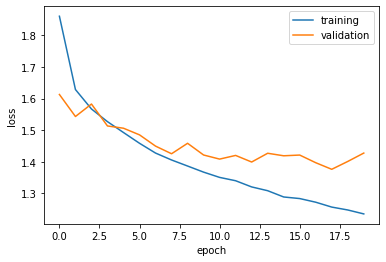

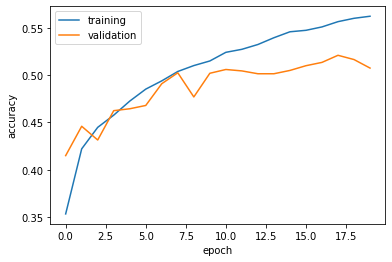

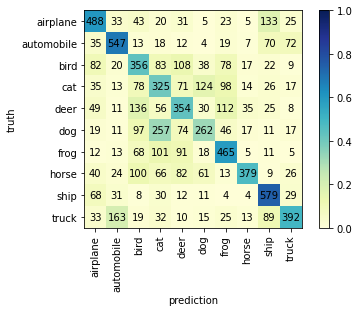

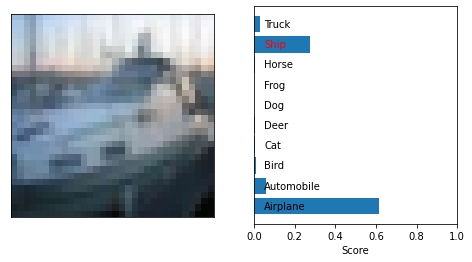

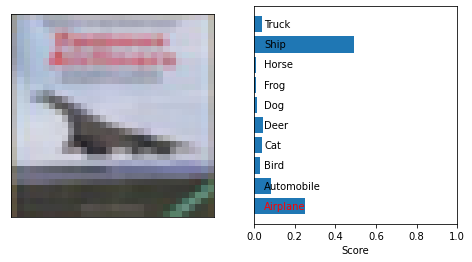

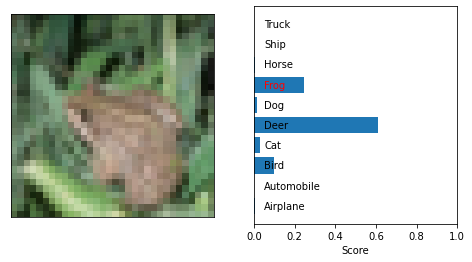

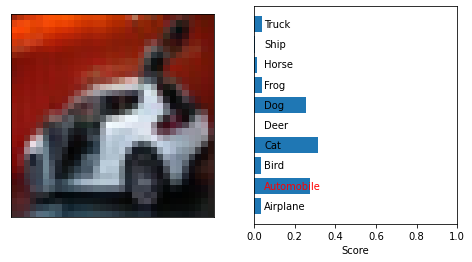

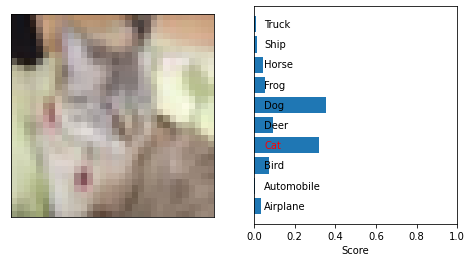

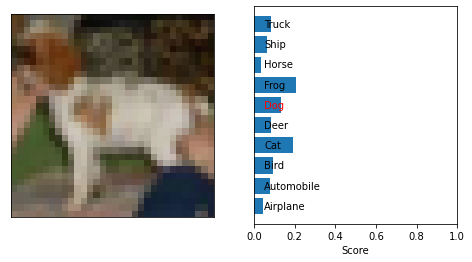

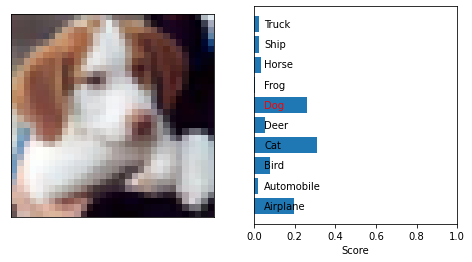

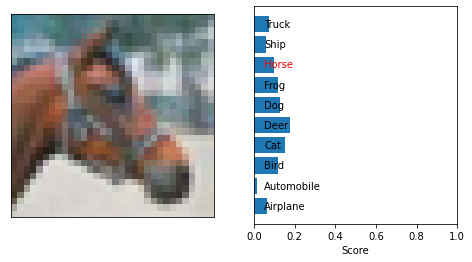

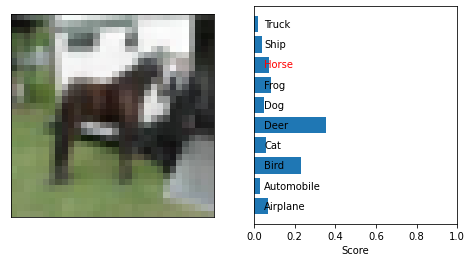

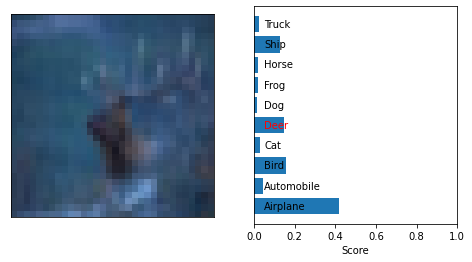

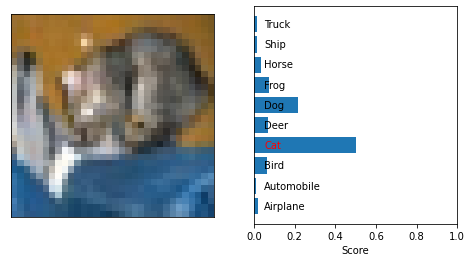

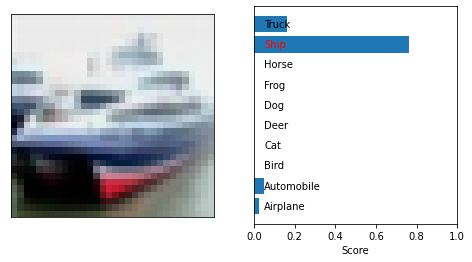

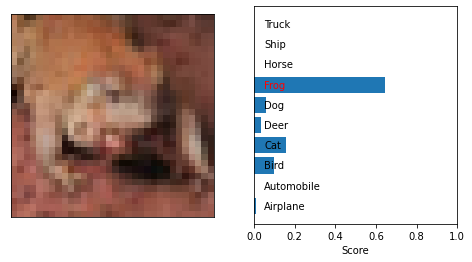

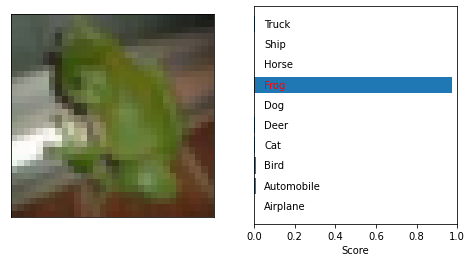

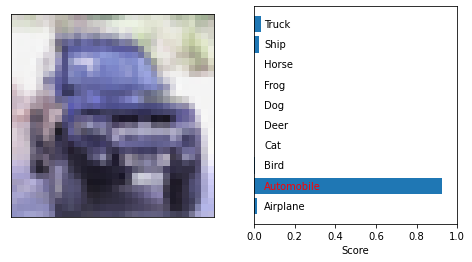

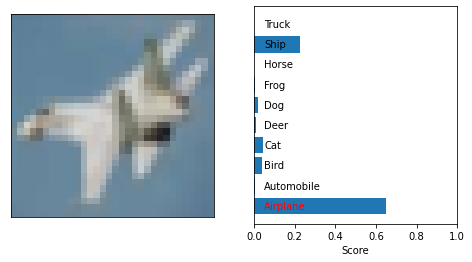

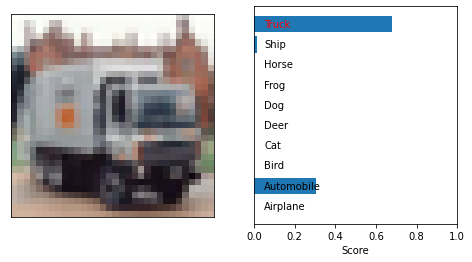

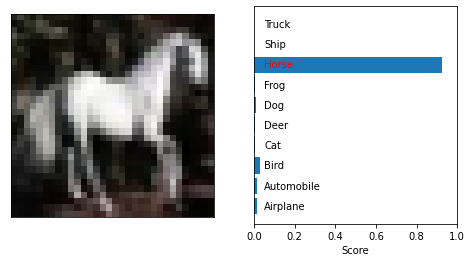

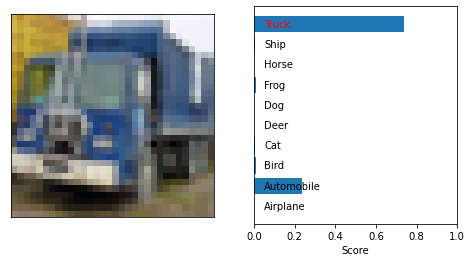

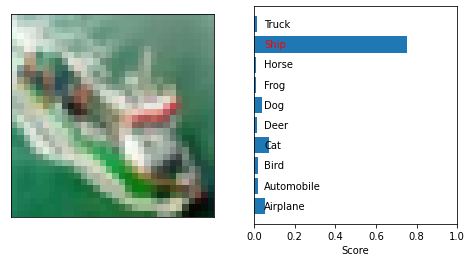

In [ ]:
# ----------------------------------------------------------
# Plots
# ----------------------------------------------------------
# training curves
history = np.genfromtxt("history_{}.csv".format(model.name), delimiter=",", names=True)

fig, ax = plt.subplots(1)
ax.plot(history["epoch"], history["loss"], label="training")
ax.plot(history["epoch"], history["val_loss"], label="validation")
ax.legend()
ax.set(xlabel="epoch", ylabel="loss")

fig, ax = plt.subplots(1)
ax.plot(history["epoch"], history["accuracy"], label="training")
ax.plot(history["epoch"], history["val_accuracy"], label="validation")
ax.legend()
ax.set(xlabel="epoch", ylabel="accuracy")

# calculate predictions for test set
y_predict = model.predict(x_test_norm, batch_size=128)

# convert back to class labels (0-9)
y_predict_cl = np.argmax(y_predict, axis=1)
y_test_cl = np.argmax(y_test_onehot, axis=1)

# plot confusion matrix
plot_confusion(
    y_test_cl, y_predict_cl
)

# compare prediction and truth
m = y_predict_cl == y_test_cl
i0 = np.arange(8000)[~m]  # misclassified images
i1 = np.arange(8000)[m]  # correctly classified images

# original (unnormalized) test images
x_test = x_test[:8000]

# plot first 10 false classifications
for i in i0[0:10]:
    plot_prediction(x_test[i], y_test_onehot[i], y_predict[i])

# plot first 10 correct classifications
for i in i1[0:10]:
    plot_prediction(x_test[i], y_test_onehot[i], y_predict[i])


**CNN**


In [ ]:
model = tf.keras.models.Sequential(
    [
        layers.Conv2D(16, kernel_size=(3, 3), padding="same", activation="relu", input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu"),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(10, activation="softmax"),
    ],
    name="cnn",
)

print(model.summary())

Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                20490   

In [ ]:
# ----------------------------------------------------------
# Training
# ----------------------------------------------------------
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["accuracy"],
)

model.fit(
    x_train_norm,
    y_train_onehot,
    batch_size=32,
    epochs=40,
    validation_data=(x_valid_norm, y_valid_onehot),
    callbacks=[tf.keras.callbacks.CSVLogger("history_{}.csv".format(model.name))],
)

Epoch 1/40
1563/1563 [==============================] - 38s 5ms/step - loss: 1.4759 - accuracy: 0.4745 - val_loss: 1.2330 - val_accuracy: 0.5515
Epoch 2/40
1563/1563 [==============================] - 8s 5ms/step - loss: 1.1865 - accuracy: 0.5831 - val_loss: 1.0690 - val_accuracy: 0.6335
Epoch 3/40
1563/1563 [==============================] - 8s 5ms/step - loss: 1.0876 - accuracy: 0.6192 - val_loss: 0.9927 - val_accuracy: 0.6470
Epoch 4/40
1563/1563 [==============================] - 9s 6ms/step - loss: 1.0270 - accuracy: 0.6406 - val_loss: 0.9358 - val_accuracy: 0.6795
Epoch 5/40
1563/1563 [==============================] - 9s 5ms/step - loss: 0.9916 - accuracy: 0.6537 - val_loss: 0.9113 - val_accuracy: 0.6875
Epoch 6/40
1563/1563 [==============================] - 8s 5ms/step - loss: 0.9675 - accuracy: 0.6611 - val_loss: 0.9047 - val_accuracy: 0.6815
Epoch 7/40
1563/1563 [==============================] - 8s 5ms/step - loss: 0.9488 - accuracy: 0.6675 - val_loss: 0.8951 - val_accuracy

In [ ]:
print("Model performance :")
headers = ["", "Loss", "Accuracy"]

table = [
    ["Train", *model.evaluate(x_train_norm, y_train_onehot, verbose=0, batch_size=128)],
    ["Validation", *model.evaluate(x_valid_norm, y_valid_onehot, verbose=0, batch_size=128)],
    ["Test", *model.evaluate(x_test_norm, y_test_onehot, verbose=0, batch_size=128)],
]

print(tabulate(table, headers=headers, tablefmt="orgtbl"))

Model performance :
|            |     Loss |   Accuracy |
|------------+----------+------------|
| Train      | 0.616278 |   0.79144  |
| Validation | 0.784075 |   0.721    |
| Test       | 0.804366 |   0.722125 |


[Text(0, 0.5, 'accuracy'), Text(0.5, 0, 'epoch')]

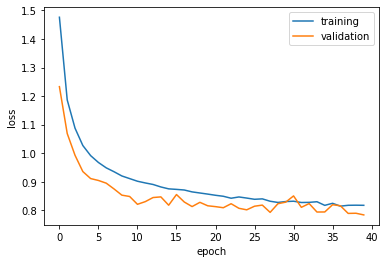

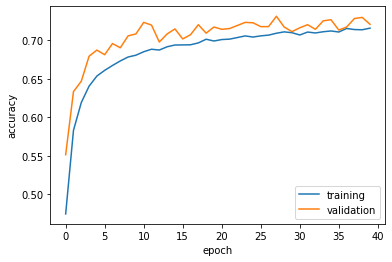

In [ ]:
# ----------------------------------------------------------
# Plots
# ----------------------------------------------------------
# training curves
history = np.genfromtxt("history_{}.csv".format(model.name), delimiter=",", names=True)

fig, ax = plt.subplots(1)
ax.plot(history["epoch"], history["loss"], label="training")
ax.plot(history["epoch"], history["val_loss"], label="validation")
ax.legend()
ax.set(xlabel="epoch", ylabel="loss")

fig, ax = plt.subplots(1)
ax.plot(history["epoch"], history["accuracy"], label="training")
ax.plot(history["epoch"], history["val_accuracy"], label="validation")
ax.legend()
ax.set(xlabel="epoch", ylabel="accuracy")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


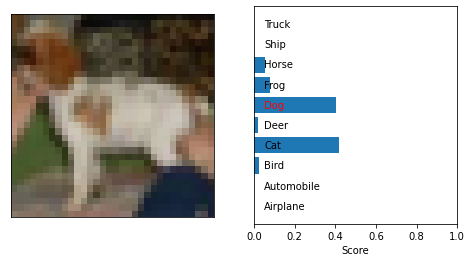

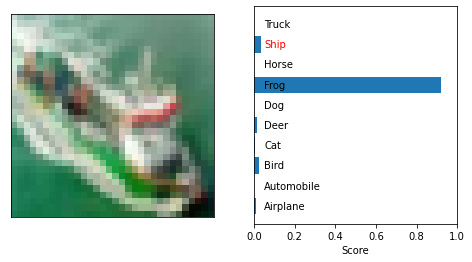

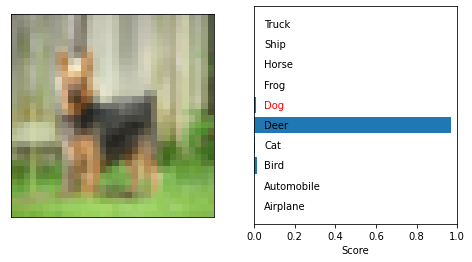

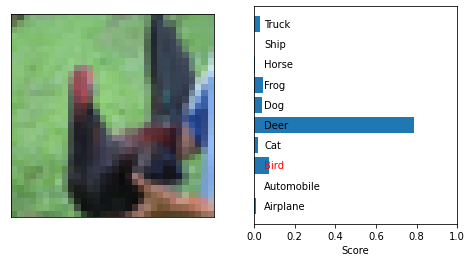

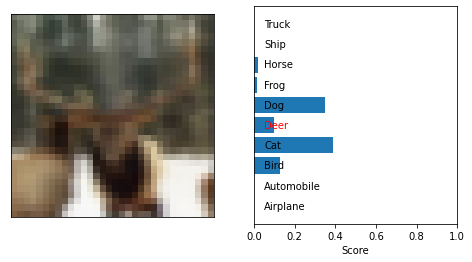

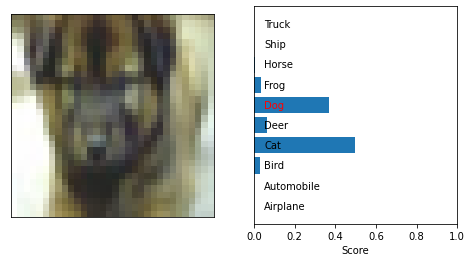

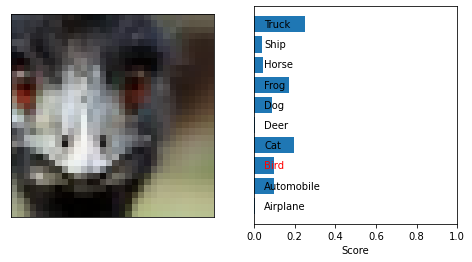

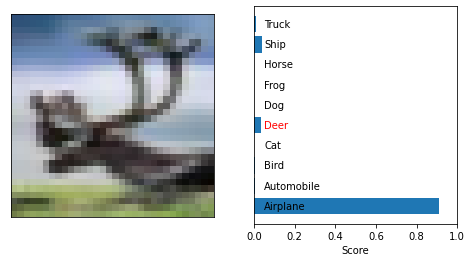

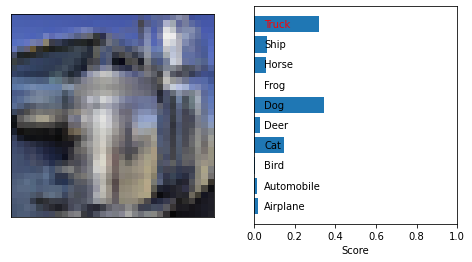

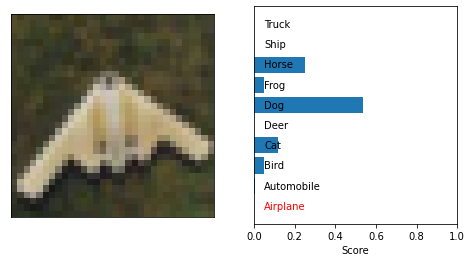

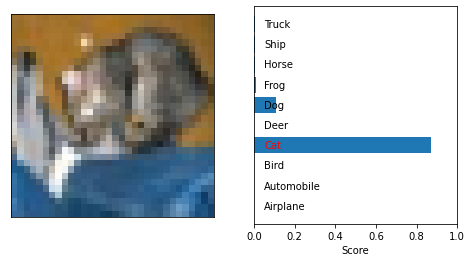

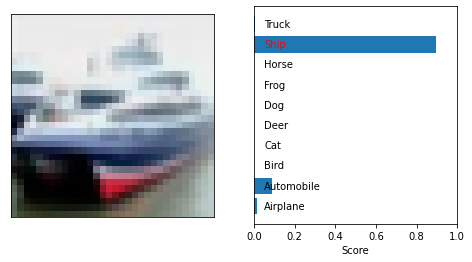

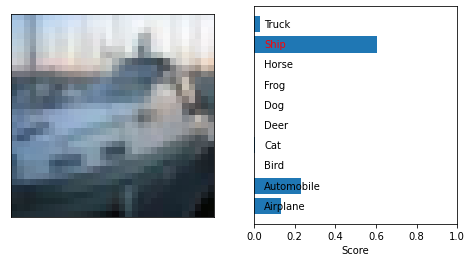

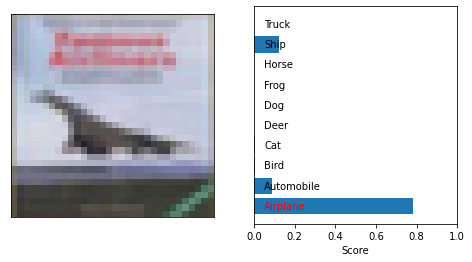

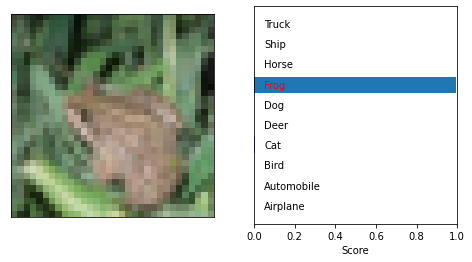

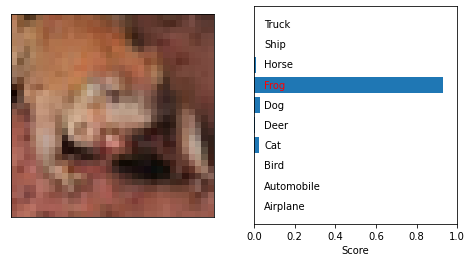

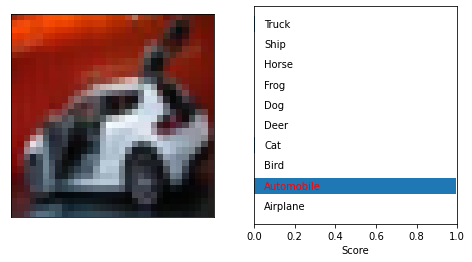

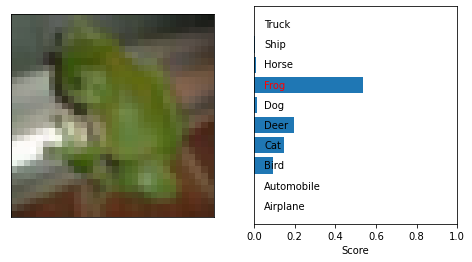

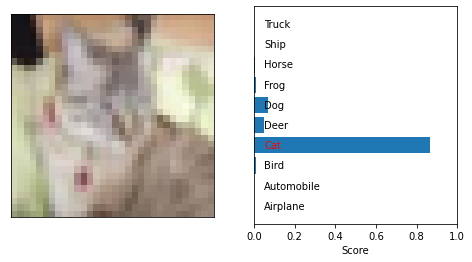

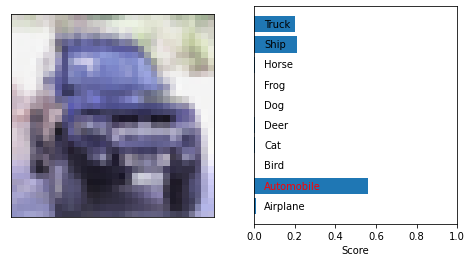

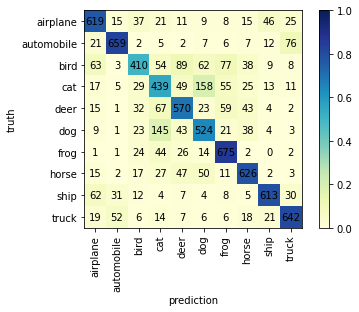

In [ ]:
# calculate predictions for test set
y_predict = model.predict(x_test_norm, batch_size=128)

# convert back to class labels (0-9)
y_predict_cl = np.argmax(y_predict, axis=1)
y_test_cl = np.argmax(y_test_onehot, axis=1)

# compare prediction and truth
m = y_predict_cl == y_test_cl
i0 = np.arange(8000)[~m]  # misclassified images
i1 = np.arange(8000)[m]  # correctly classified images

# original (unnormalized) test images
x_test = x_test[:8000]

# plot first 10 false classifications
for i in i0[0:10]:
    plot_prediction(x_test[i], y_test_onehot[i], y_predict[i])

# plot first 10 correct classifications
for i in i1[0:10]:
    plot_prediction(x_test[i], y_test_onehot[i], y_predict[i])

# plot confusion matrix
plot_confusion(
    y_test_cl, y_predict_cl
)

**Deep CNN**
Solution to exercise 7.2

In [ ]:
# ----------------------------------------------------------
# Define model
# ----------------------------------------------------------
model = tf.keras.models.Sequential(name="dcnn")


def add_block(nfilters, dropout=False, **kwargs):
    """
    Add basic convolution block:
     - 3x3 Convolution with padding
     - Activation: ReLU
     - either MaxPooling to reduce resolution, or Dropout
     - BatchNormalization
    """
    model.add(layers.Convolution2D(nfilters, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal", **kwargs))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation("relu"))
    if dropout:
        model.add(layers.Dropout(dropout))
    else:
        model.add(layers.MaxPooling2D((2, 2), padding="same"))


# convolution part
add_block(32, dropout=0.3, input_shape=(32, 32, 3))  # --> (32, 32, 32)
add_block(32)  # --> (16, 16,  32)
add_block(64, dropout=0.4)  # --> (16, 16,  64)
add_block(64)  # --> ( 8,  8,  64)
add_block(128, dropout=0.4)  # --> ( 8,  8, 128)
add_block(128, dropout=0.4)  # --> ( 8,  8, 128)
add_block(128)  # --> ( 4,  4, 128)
add_block(256, dropout=0.4)  # --> ( 4,  4, 256)
add_block(256, dropout=0.4)  # --> ( 4,  4, 256)
add_block(256)  # --> ( 2,  2, 256)

# classification part
model.add(layers.Flatten())  # --> (1024)
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256))  # --> (256)
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10))  # --> (10)
model.add(layers.Activation("softmax"))

print(model.summary())

Model: "dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0      

In [ ]:
# ----------------------------------------------------------
# Training
# ----------------------------------------------------------
model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["accuracy"],
)

batch_size = 32
model.fit(
    x_train_norm,
    y_train_onehot,
    batch_size=batch_size,
    epochs=20,
    validation_data=(x_valid_norm, y_valid_onehot),
    callbacks=[tf.keras.callbacks.CSVLogger("history_{}.csv".format(model.name))],
)

Epoch 1/20
1563/1563 [==============================] - 50s 30ms/step - loss: 1.7681 - accuracy: 0.3555 - val_loss: 1.5691 - val_accuracy: 0.4710
Epoch 2/20
1563/1563 [==============================] - 47s 30ms/step - loss: 1.2361 - accuracy: 0.5579 - val_loss: 1.1852 - val_accuracy: 0.5765
Epoch 3/20
1563/1563 [==============================] - 47s 30ms/step - loss: 1.0248 - accuracy: 0.6422 - val_loss: 1.0180 - val_accuracy: 0.6340
Epoch 4/20
1563/1563 [==============================] - 47s 30ms/step - loss: 0.8993 - accuracy: 0.6880 - val_loss: 0.7928 - val_accuracy: 0.7285
Epoch 5/20
1563/1563 [==============================] - 47s 30ms/step - loss: 0.8146 - accuracy: 0.7216 - val_loss: 0.8619 - val_accuracy: 0.7020
Epoch 6/20
1563/1563 [==============================] - 47s 30ms/step - loss: 0.7512 - accuracy: 0.7432 - val_loss: 0.6843 - val_accuracy: 0.7555
Epoch 7/20
1563/1563 [==============================] - 47s 30ms/step - loss: 0.7103 - accuracy: 0.7582 - val_loss: 0.7703 -

In [ ]:
print("Model performance :")
headers = ["", "Loss", "Accuracy"]

table = [
    ["Train", *model.evaluate(x_train_norm, y_train_onehot, verbose=0, batch_size=128)],
    ["Validation", *model.evaluate(x_valid_norm, y_valid_onehot, verbose=0, batch_size=128)],
    ["Test", *model.evaluate(x_test_norm, y_test_onehot, verbose=0, batch_size=128)],
]

print(tabulate(table, headers=headers, tablefmt="orgtbl"))


Model performance :
|            |     Loss |   Accuracy |
|------------+----------+------------|
| Train      | 0.258251 |   0.90866  |
| Validation | 0.454459 |   0.8425   |
| Test       | 0.468933 |   0.843875 |


[Text(0, 0.5, 'accuracy'), Text(0.5, 0, 'epoch')]

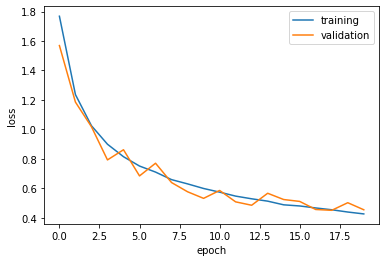

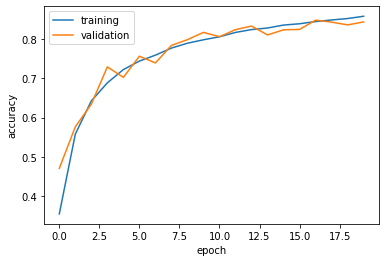

In [ ]:
# ----------------------------------------------------------
# Plots
# ----------------------------------------------------------
# training curves
history = np.genfromtxt("history_{}.csv".format(model.name), delimiter=",", names=True)

fig, ax = plt.subplots(1)
ax.plot(history["epoch"], history["loss"], label="training")
ax.plot(history["epoch"], history["val_loss"], label="validation")
ax.legend()
ax.set(xlabel="epoch", ylabel="loss")

fig, ax = plt.subplots(1)
ax.plot(history["epoch"], history["accuracy"], label="training")
ax.plot(history["epoch"], history["val_accuracy"], label="validation")
ax.legend()
ax.set(xlabel="epoch", ylabel="accuracy")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


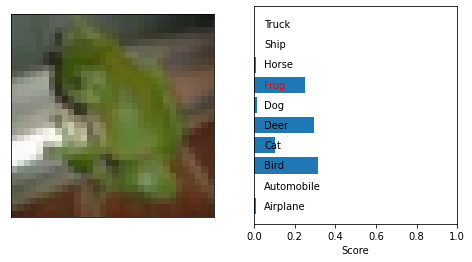

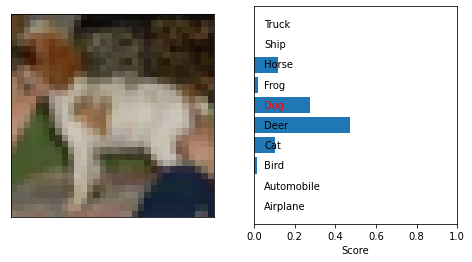

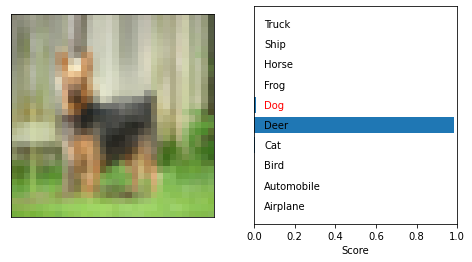

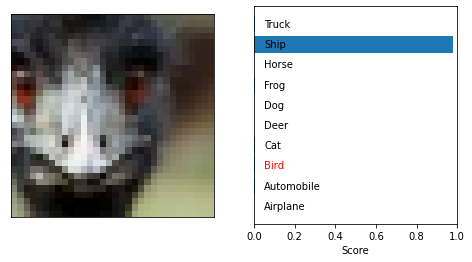

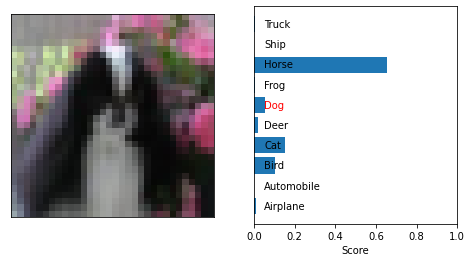

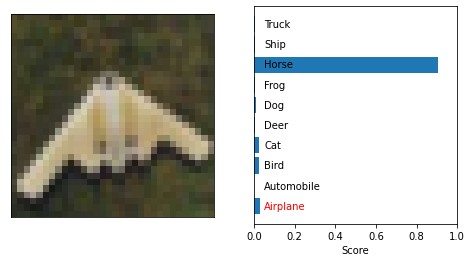

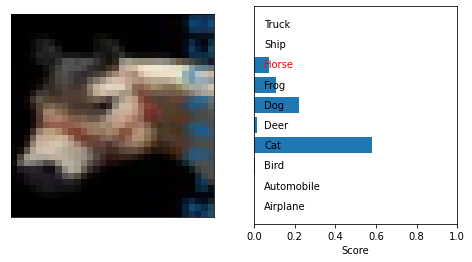

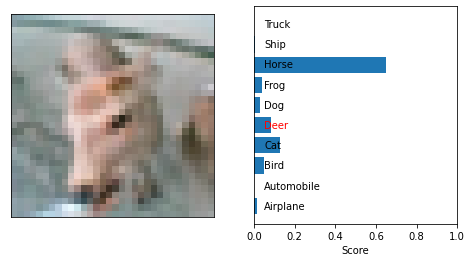

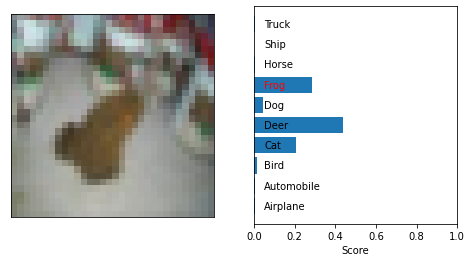

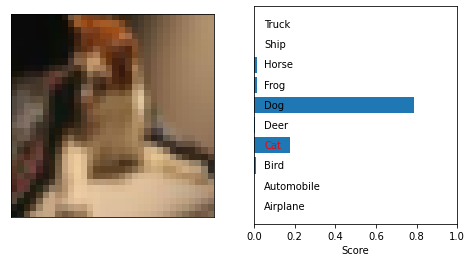

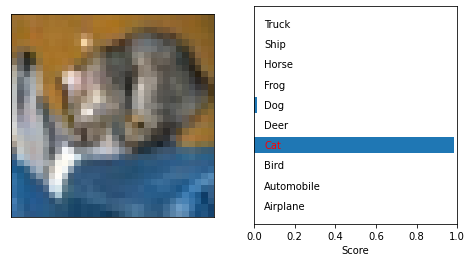

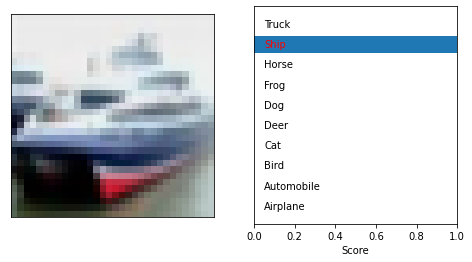

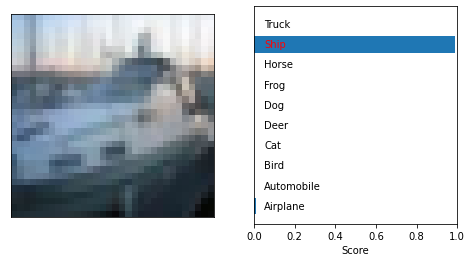

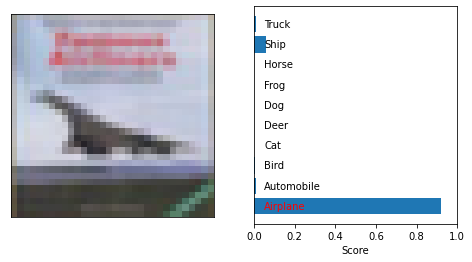

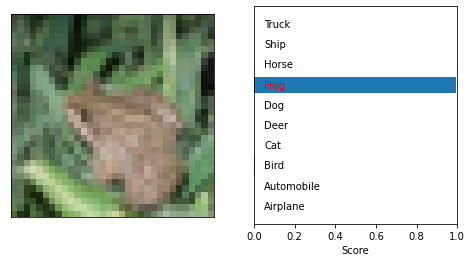

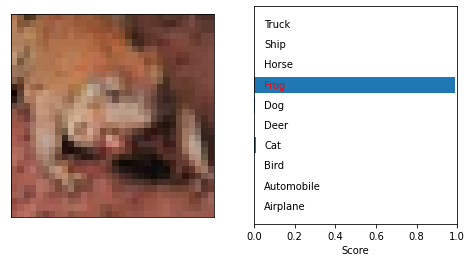

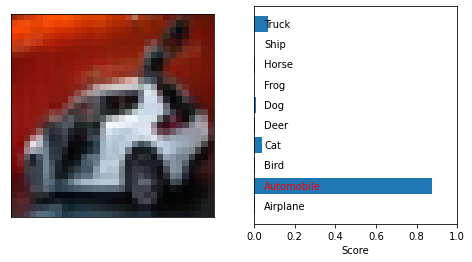

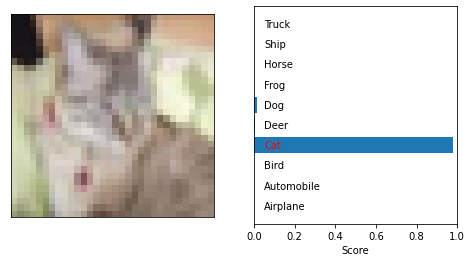

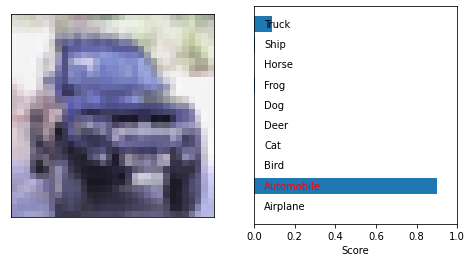

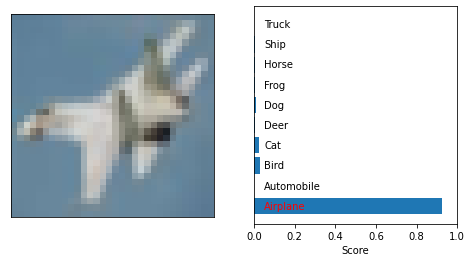

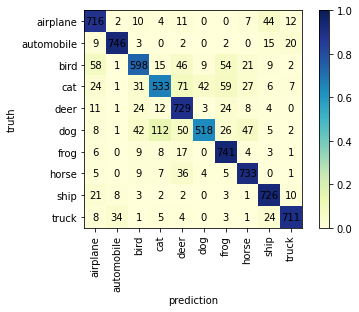

In [ ]:
# calculate predictions for test set
y_predict = model.predict(x_test_norm, batch_size=128)

# convert back to class labels (0-9)
y_predict_cl = np.argmax(y_predict, axis=1)
y_test_cl = np.argmax(y_test_onehot, axis=1)

# compare prediction and truth
m = y_predict_cl == y_test_cl
i0 = np.arange(8000)[~m]  # misclassified images
i1 = np.arange(8000)[m]  # correctly classified images

# original (unnormalized) test images
x_test = x_test[:8000]

# plot first 10 false classifications
for i in i0[0:10]:
    plot_prediction(x_test[i], y_test_onehot[i], y_predict[i])

# plot first 10 correct classifications
for i in i1[0:10]:
    plot_prediction(x_test[i], y_test_onehot[i], y_predict[i])

# plot confusion matrix
plot_confusion(
    y_test_cl, y_predict_cl
)